In [1]:
# !pip install joblib six
# !pip install 'gym[all]'
# !pip install pyglet==1.2.4
# !pip install pyvirtualdisplay
# !pip install --no-cache-dir -I pillow

In [2]:
import matplotlib.pyplot as plt
import gym
import numpy as np
import scipy
from joblib import Parallel, delayed
import matplotlib.animation as animation 
from IPython.core.debugger import set_trace
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """
    
    reward_threshold = np.percentile(rewards_batch, percentile)
    states_batch = np.array(states_batch)
    actions_batch = np.array(actions_batch)
    
    elite_mask = rewards_batch >= reward_threshold
    elite_states  = states_batch[elite_mask]
    elite_actions = actions_batch[elite_mask]
#     set_trace()

#     if elite_states != []:
    elite_states = np.concatenate(elite_states)
    elite_actions = np.concatenate(elite_actions)
    
    return elite_states,elite_actions

In [4]:
from IPython.display import clear_output

def show_progress(rewards_batch,log):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(rewards_batch,range=[min(rewards_batch), max(rewards_batch)]);
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()


In [5]:
env = gym.make("LunarLander-v2")
# env = gym.wrappers.Monitor(env, '/Users/onotole/Coding/ML/ml_notebooks/RL', force=True)
env.reset()
n_actions = env.action_space.n

# plt.imshow(env.render("rgb_array"));

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [6]:
n_actions

4

In [26]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(hidden_layer_sizes=(20, 20),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1, #make only 1 iteration on each .fit(...)
                     )

#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions, range(n_actions));

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [27]:
def generate_session(t_max=500):
    states,actions = [],[]
    total_rewards = 0
    s = env.reset()
    
    for t in range(t_max):
        probs = agent.predict_proba([s])[0]
        a = np.random.choice(n_actions, p=probs)
        new_s, r, done, _ = env.step(a)
        
        states.append(s)
        actions.append(a)
        total_rewards += r
        s = new_s[:]
        if done: break
    return states, actions, total_rewards
        

mean reward = 53.103, threshold=107.663


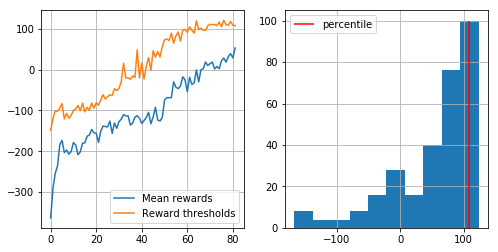

iteration time: 41 s
You win
CPU times: user 1min 30s, sys: 14 s, total: 1min 44s
Wall time: 24min 22s


In [28]:
%%time
n_sessions = 300
percentile = 90
log = []
epochs = 1000
value_to_stop = 50

for i in range(epochs):
    t = dt.now()
    sessions = Parallel(n_jobs=4)(delayed(generate_session)() for _ in range(n_sessions))
    
#     sessions = [generate_session() for _ in range(n_sessions)]
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    elite_states, elite_actions = select_elites(states_batch,
                                                actions_batch,
                                                rewards_batch,
                                                percentile=percentile)

    agent.fit(elite_states, elite_actions)
    
    show_progress(rewards_batch, log)
    print("iteration time: {t} s".format(t=(dt.now() - t).seconds))
    if np.mean(rewards_batch) > value_to_stop:
        print("You win")
        break
    

In [46]:
# env.reset()
total_reward = 0
t_max=1000


s = env.reset()

for t in range(t_max):
        env.render()
        
        probs = agent.predict_proba([s])[0] 
        
        a = np.random.choice(n_actions, p=probs)
        
        new_s,r,done,info = env.step(a)
        if r > 20:
            print(r)
            break
        total_reward+=r
        
        s = new_s
        if done: break

In [31]:
import matplotlib.animation as animation 

def make_video(frames):
    # Cоздаем окно, в которое будем писать кадры:
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow([[0]])

    # Конвертируем кадры в видео:
    video = animation.FuncAnimation(fig, im.set_data, frames)
    video.save('demo.mp4', writer=animation.FFMpegWriter(), dpi=100)

    # Cкачиваем файлы с colab:
#     files.download('demo.mp4')